## Kinetics Model: Predicting IEDDA Reaction Rates

The goal of this notebook is to develop a machine learning model that is able to predict second-order rate constants (k2) for inverse electron-demand Diels-Alder (IEDDA) reactions using molecular descriptors.

**Dataset:** Svatunek et al. kinetics dataset containing computationally generated k2 values for IEDDA reactions. The SMILES strings from this dataset are enriched by RDKit and Mordred descriptors. 

In [104]:
%pip install pandas numpy scipy matplotlib seaborn scikit-learn rdkit mordred boruta xgboost shap optuna



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Prepare Packages


In [ ]:
import pandas as pd
import numpy as np
import random
import pickle
import json
import warnings
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from mordred import Calculator, descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from boruta import BorutaPy
from xgboost import XGBRegressor
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle
import json

warnings.filterwarnings('ignore')

### Train The Model

#### Load Datasets

In [106]:
df = pd.read_csv("/Users/tjalling/Desktop/Capstone_Def/Datasets/Kinetics Model/svatunek_k2_dataset.csv", sep=',')
df = df.drop(columns=['Notes', 'Source'])

df.head(100)

,Compound,k2,log_k2,SMILES
0,T0919 + TCO,5.357090e+11,11.728929,O=N(=O)c2nnc(c1ncncn1)nn2
1,T0917 + TCO,4.563902e+11,11.659336,O=N(=O)c2nnc(c1ncncc1)nn2
2,T0916 + TCO,4.034550e+11,11.605795,O=N(=O)c2nnc(c1ncccn1)nn2
3,T0937 + TCO,3.525304e+11,11.547197,O=N(=O)c2nnc(C(OC)=C)nn2
4,T0913 + TCO,3.451131e+11,11.537961,O=N(=O)c2nnc(c1ncccc1)nn2
...,...,...,...,...
95,T0795 + TCO,7.902699e+10,10.897775,NC(=O)c2nnc(c1cncnc1)nn2
96,T0792 + TCO,7.876734e+10,10.896346,NC(=O)c2nnc(c1ccncc1)nn2
97,T1030 + TCO,7.862789e+10,10.895577,c1cc(N(=O)=O)ccc1c2nnc(C(=O)N)nn2
98,T0577 + TCO,7.809230e+10,10.892608,COC(=C)c2nnc(c1ncncn1)nn2


#### Add Descriptors

##### Manual Descriptors

Add RDKit descriptors. 

In [ ]:

def add_molecular_descriptors_to_dataframe(df, smiles_column='SMILES'):
    """
    Add molecular descriptors to dataframe from SMILES strings
    """
    # Internet-derived descriptor List
    chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']
    
    # Create calculator
    calculator = MolecularDescriptorCalculator(chosen_descriptors)
    
    # Initialize list to store all descriptor values
    all_descriptors = []
    failed_smiles = []
    
    # Process each SMILES string
    for idx, smiles in enumerate(df[smiles_column]):
        try:
            # Convert SMILES to mol object
            mol = Chem.MolFromSmiles(smiles)
            
            if mol is not None:
                # Calculate descriptors
                descriptors = list(calculator.CalcDescriptors(mol))
                all_descriptors.append(descriptors)
            else:
                # Handle invalid SMILES
                print(f"Invalid SMILES at index {idx}: {smiles}")
                all_descriptors.append([np.nan] * len(chosen_descriptors))
                failed_smiles.append(idx)
                
        except Exception as e:
            print(f"Error processing SMILES at index {idx}: {smiles}, Error: {e}")
            all_descriptors.append([np.nan] * len(chosen_descriptors))
            failed_smiles.append(idx)
    
    # Create dataframe with descriptors
    descriptors_df = pd.DataFrame(all_descriptors, columns=chosen_descriptors)
    
    # Combine with original dataframe
    result_df = pd.concat([df.reset_index(drop=True), descriptors_df], axis=1)
    
    if failed_smiles:
        print(f"Failed to process {len(failed_smiles)} SMILES")
    
    return result_df

# Add molecular descriptors
df_with_descriptors = add_molecular_descriptors_to_dataframe(df, smiles_column='SMILES')

# Save the enriched dataset
df_with_descriptors.to_csv('svatunek_k2_dataset_with_descriptors.csv', index=False)

df_with_descriptors = df_with_descriptors.drop(columns=['k2', "Compound"])

##### Morded Descriptors

Add descriptors using the Morded Package

In [110]:
def append_mordred_descriptors(df, smiles_column='SMILES'):
    calc = Calculator(descriptors, ignore_3D=True)
    mordred_features = []
    failed_indices = []

    for idx, smiles in enumerate(df[smiles_column]):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            try:
                desc = calc(mol)
                mordred_features.append(list(desc))
            except Exception as e:
                print(f"Error at index {idx}: {e}")
                mordred_features.append([None]*len(calc.descriptors))
                failed_indices.append(idx)
        else:
            print(f"Invalid SMILES at index {idx}: {smiles}")
            mordred_features.append([None]*len(calc.descriptors))
            failed_indices.append(idx)

    mordred_df = pd.DataFrame(mordred_features, columns=[str(d) for d in calc.descriptors])
    mordred_df.index = df.index  # Ensure indices align
    # Merge with the original DataFrame
    df_with_mordred = pd.concat([df, mordred_df], axis=1)
    return df_with_mordred

df_with_mordred = append_mordred_descriptors(df_with_descriptors, smiles_column='SMILES')

#### Clean The Data & Feature Selection

Drop columns with >5% missing/infinite values (unreliable descriptors) and use BorutaPy for feature selection instead of using all 1367 descriptors

In [112]:
# Make a copy to avoid modifying original data
df_cleaned = df_with_mordred.copy()

# Step 1: Drop columns with >5% NaN
threshold = 0.05
nan_fraction = df_cleaned.isna().mean()
df_cleaned = df_cleaned.loc[:, nan_fraction <= threshold]

# Step 2: Drop columns with >5% inf or -inf
inf_mask = df_cleaned.applymap(lambda x: np.isinf(x) if isinstance(x, (float, int)) else False)
inf_fraction = inf_mask.mean()
df_cleaned = df_cleaned.loc[:, inf_fraction <= threshold]

# Step 3: Drop columns with any non-numeric values
def is_column_fully_float(col):
    try:
        pd.to_numeric(col, errors='raise')
        return True
    except:
        return False

float_compatible_cols = [col for col in df_cleaned.columns if is_column_fully_float(df_cleaned[col])]
df_cleaned = df_cleaned[float_compatible_cols + ['Compound', 'k2', 'log_k2', 'Source', 'Notes', 'SMILES'] if 'Compound' in df_cleaned.columns else float_compatible_cols]

# Clean feature selection (exclude both k2 and log_k2)
descriptor_columns = [col for col in df_cleaned.columns 
                     if col not in ['Compound', 'k2', 'log_k2', 'Source', 'Notes', 'SMILES']]

X = df_cleaned[descriptor_columns].fillna(0)
y = df_cleaned['log_k2']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_selector = BorutaPy(RandomForestRegressor(n_jobs=-1, max_depth=None), 
                             n_estimators='auto', 
                             verbose=2, 
                             random_state=42)

feature_selector.fit(X_scaled, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	9 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	10 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	11 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	12 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	13 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	14 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	15 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iterat

BorutaPy(estimator=RandomForestRegressor(n_estimators=197, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x3C9EBDB40),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x3C9EBDB40,
         verbose=2)

##### Delete Useless Columns

Delete the columns boruta deemed unuseful. 

In [113]:
# Get selected feature names from Boruta
selected_mask = feature_selector.support_
selected_features = X.columns[selected_mask]

# Subset scaled feature arrays using column names
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_features]

#### Train/Test Split Strategy

Using a scaffold split instead of a random split for final model evaluation because random splits leak information. With a random split similar molecules end up in both train and test sets, which inflates the performance metrics. Scaffold splitting groups molecules by core structure, which makes sure that the model is tested on truly novel chemical scaffolds. This better represents real-world use: predicting rates for new molecules we haven't synthesized yet.

##### Random Split

In [114]:
# Random split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42
)

# Random split the data into training and test set
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42
)

##### Scaffold Split

In [115]:
smiles_arr = df_with_mordred['SMILES'].values  

# Create Murcko Scaffold Function
def murcko_scaffold(smi: str) -> str:
    """Return Bemis–Murcko scaffold SMILES (no chirality)."""
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        raise ValueError(f"Bad SMILES: {smi}")
    # try Mol signature first, fall back to SMILES signature
    try:
        return MurckoScaffold.MurckoScaffoldSmiles(mol, includeChirality=False)
    except TypeError:
        return MurckoScaffold.MurckoScaffoldSmiles(smi, includeChirality=False)

# Create a 80/20 Scaffold Split 
def scaffold_split_random(smiles, frac_test=0.20, seed=42):
    """
    Allocate whole scaffold families to test set until quota reached, but shuffle scaffold order first so we don't end up with a single huge family.
    """
    random.seed(seed)
    # group row indices by scaffold
    buckets = {}
    for idx, smi in enumerate(smiles):
        scaf = murcko_scaffold(smi)
        buckets.setdefault(scaf, []).append(idx)

    # shuffle scaffold order for diversity
    scaf_items = list(buckets.items())
    random.shuffle(scaf_items)

    test_idx, train_idx = [], []
    for _, idxs in scaf_items:
        if len(test_idx) / len(smiles) < frac_test:
            test_idx.extend(idxs)
        else:
            train_idx.extend(idxs)

    # sanity-check: if still <10 scaffolds in test, force-move extra ones
    if len({murcko_scaffold(smiles[i]) for i in test_idx}) < 10:
        for scaf, idxs in scaf_items:
            if set(idxs).issubset(test_idx):   # already in test
                continue
            test_idx.extend(idxs)
            train_idx = [i for i in train_idx if i not in idxs]
            if len({murcko_scaffold(smiles[i]) for i in test_idx}) >= 10:
                break

    return np.array(train_idx), np.array(test_idx)

# Run split and slice every matrix 
X_scaled_np   = np.asarray(X_scaled)
X_selected_np = np.asarray(X_selected)
y_np          = np.asarray(y)

train_idx, test_idx = scaffold_split_random(smiles_arr, frac_test=0.20, seed=42)

X_train_scaffold            = X_scaled_np[train_idx]
X_test_scaffold             = X_scaled_np[test_idx]

X_train_scaffold_selected   = X_selected_np[train_idx]
X_test_scaffold_selected    = X_selected_np[test_idx]

y_train_scaffold            = y_np[train_idx]
y_test_scaffold             = y_np[test_idx]

train_scaf = {murcko_scaffold(smiles_arr[i]) for i in train_idx}
test_scaf  = {murcko_scaffold(smiles_arr[i]) for i in test_idx}

print(f"Train: {len(train_idx)} samples, {len(train_scaf)} scaffolds")
print(f"Test: {len(test_idx)} samples, {len(test_scaf)} scaffolds")


Train: 1007 samples, 76 scaffolds
Test: 281 samples, 37 scaffolds


#### Optuna Hyperparameter Tuning

Default hyperparameters are almost never optimal. Optuna uses Bayesian optimization (TPE sampler) to efficiently search the hyperparameter space and look for the best configuration. 

The models used are: 
- **Random Forest:** Robust, handles non-linear relationships, built-in feature importance
- **XGBoost:** Often outperforms RF on tabular data, better at capturing subtle interactions

##### Random Forest Hyperparameter Tuning


In [116]:
def objective_rf(trial):
    """
    Optuna objective function for Random Forest hyperparameter tuning
    Uses scaffold split with all features
    """
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Train model with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=1000,
        n_jobs=-1
    )
    
    # Fit on training data
    model.fit(X_train_scaffold, y_train_scaffold)
    
    # Evaluate on test data
    test_score = model.score(X_test_scaffold, y_test_scaffold)
    
    return test_score

study_rf = optuna.create_study(
    direction='maximize',
    study_name='rf_scaffold_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=False)

print(f"RF - Best R²: {study_rf.best_value:.4f}")


[I 2025-11-02 13:55:33,793] A new study created in memory with name: rf_scaffold_optimization
[I 2025-11-02 13:55:34,128] Trial 0 finished with value: 0.8050656404610311 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8050656404610311.
[I 2025-11-02 13:55:34,802] Trial 1 finished with value: 0.8144981717342895 and parameters: {'n_estimators': 300, 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8144981717342895.
[I 2025-11-02 13:55:41,209] Trial 2 finished with value: 0.8485688107848256 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.8485688107848256.
[I 2025-11-02 13:55:41,365] Trial 3 finished with value: 0.7916714278290371 and parameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5, '

RF - Best R²: 0.8564


In [117]:
# Visualize optimization history
fig1 = plot_optimization_history(study_rf)
fig1.update_layout(title="Random Forest: Optimization History")
fig1.show()

# Visualize parameter importances
fig2 = plot_param_importances(study_rf)
fig2.update_layout(title="Random Forest: Hyperparameter Importances")
fig2.show()


In [118]:
# Train final Random Forest model with best hyperparameters
rf_best_params = study_rf.best_params
classifier_rf_optimized = RandomForestRegressor(
    **rf_best_params,
    random_state=1000,
    n_jobs=-1
)
classifier_rf_optimized.fit(X_train_scaffold, y_train_scaffold)

train_score_optimized = classifier_rf_optimized.score(X_train_scaffold, y_train_scaffold)
test_score_optimized = classifier_rf_optimized.score(X_test_scaffold, y_test_scaffold)


##### XGBoost Hyperparameter Tuning


In [119]:
def objective_xgb(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning
    Uses scaffold split with all features
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 1000,
        'n_jobs': -1
    }
    
    # Train model with suggested hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train_scaffold, y_train_scaffold)
    
    # Evaluate on test data
    test_score = model.score(X_test_scaffold, y_test_scaffold)
    
    return test_score

study_xgb = optuna.create_study(
    direction='maximize',
    study_name='xgb_scaffold_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=False)

print(f"XGB - Best R²: {study_xgb.best_value:.4f}")


[I 2025-11-02 14:05:35,998] A new study created in memory with name: xgb_scaffold_optimization


[I 2025-11-02 14:05:37,105] Trial 0 finished with value: 0.8058105589818184 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.8058105589818184.
[I 2025-11-02 14:05:37,943] Trial 1 finished with value: 0.8230639641685561 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.8230639641685561.
[I 2025-11-02 14:05:38,695] Trial 2 finished with value: 0.7683771919541794 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.655

XGB - Best R²: 0.8879


In [120]:
# Visualize optimization history
fig3 = plot_optimization_history(study_xgb)
fig3.update_layout(title="XGBoost: Optimization History")
fig3.show()

# Visualize parameter importances
fig4 = plot_param_importances(study_xgb)
fig4.update_layout(title="XGBoost: Hyperparameter Importances")
fig4.show()


In [121]:
# Train final XGBoost model with best hyperparameters
xgb_best_params = study_xgb.best_params.copy()
xgb_best_params['random_state'] = 1000
xgb_best_params['n_jobs'] = -1

classifier_xgb_optimized = XGBRegressor(**xgb_best_params)
classifier_xgb_optimized.fit(X_train_scaffold, y_train_scaffold)

train_score_xgb_optimized = classifier_xgb_optimized.score(X_train_scaffold, y_train_scaffold)
test_score_xgb_optimized = classifier_xgb_optimized.score(X_test_scaffold, y_test_scaffold)


##### Model Comparison

Comparing the models to see which ones are the best performing. 

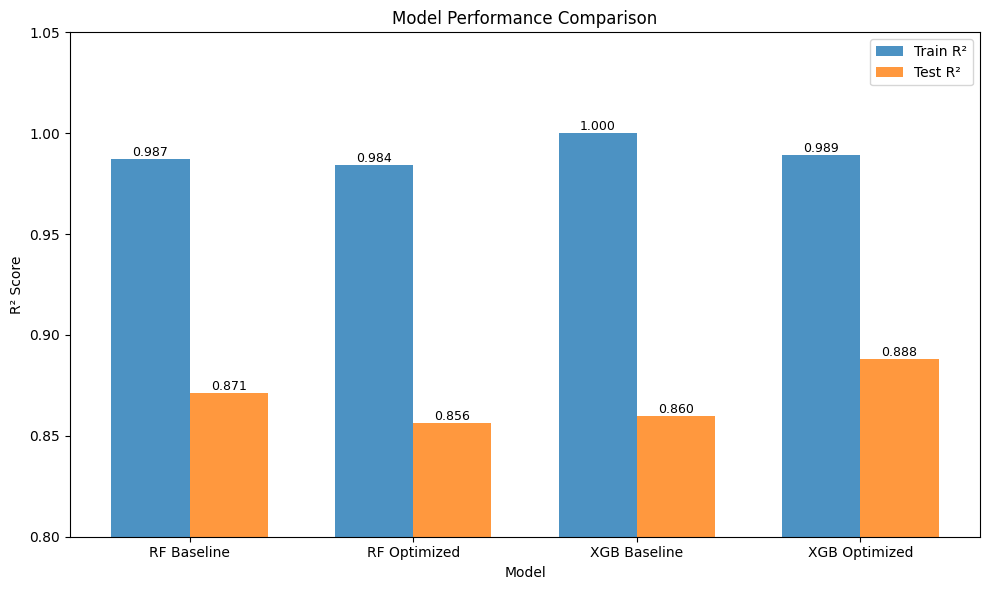

In [122]:
# Compare all models
comparison_data = {
    'Model': ['RF Baseline', 'RF Optimized', 'XGB Baseline', 'XGB Optimized'],
    'Train R²': [0.987, train_score_optimized, 1.000, train_score_xgb_optimized],
    'Test R²': [0.871, test_score_optimized, 0.860, test_score_xgb_optimized]
}

comparison_df = pd.DataFrame(comparison_data)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0.8, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


##### Save Best Models

I will use these saved models for potential reusing or testing in the future 


In [ ]:
# Save Random Forest model
with open('rf_optimized_model.pkl', 'wb') as f:
    pickle.dump(classifier_rf_optimized, f)

# Save XGBoost model
with open('xgb_optimized_model.pkl', 'wb') as f:
    pickle.dump(classifier_xgb_optimized, f)

# Save hyperparameters as JSON
hyperparams = {
    'random_forest': study_rf.best_params,
    'xgboost': study_xgb.best_params,
    'rf_test_r2': study_rf.best_value,
    'xgb_test_r2': study_xgb.best_value
}

with open('best_hyperparameters.json', 'w') as f:
    json.dump(hyperparams, f, indent=4)


### Model Evaluation & Interpretation

Analysing the model performance and producing plots to interpret the performance.

##### Model Evaluation

In [124]:
# Train all models for comprehensive comparison
classifier_rf_boruta_scaf_baseline = RandomForestRegressor(
    random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100
)
classifier_rf_boruta_scaf_baseline.fit(X_train_scaffold_selected, y_train_scaffold)

classifier_rf_rand_clean = RandomForestRegressor(
    random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100
)
classifier_rf_rand_clean.fit(X_train_selected, y_train)

rf_best_params_boruta = rf_best_params.copy()
classifier_rf_boruta_scaf_optuna = RandomForestRegressor(
    **rf_best_params_boruta,
    random_state=1000,
    n_jobs=-1
)
classifier_rf_boruta_scaf_optuna.fit(X_train_scaffold_selected, y_train_scaffold)

classifier_xgb_boruta_scaf_baseline = XGBRegressor(
    random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100
)
classifier_xgb_boruta_scaf_baseline.fit(X_train_scaffold_selected, y_train_scaffold)

classifier_xgb_boruta_rand = XGBRegressor(
    random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100
)
classifier_xgb_boruta_rand.fit(X_train_selected, y_train)

xgb_best_params_boruta = xgb_best_params.copy()
classifier_xgb_boruta_scaf_optuna = XGBRegressor(**xgb_best_params_boruta)
classifier_xgb_boruta_scaf_optuna.fit(X_train_scaffold_selected, y_train_scaffold)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6245423864231542, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.08097672059969963, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.044697966656608926,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=-1,
             num_parallel_tree=None, ...)

##### Feature Importance Analysis with SHAP

SHAP values are able to show the direction of effect of features (positive/negative on log k2), the magnitude of contribution for each prediction, and non-linear relationships

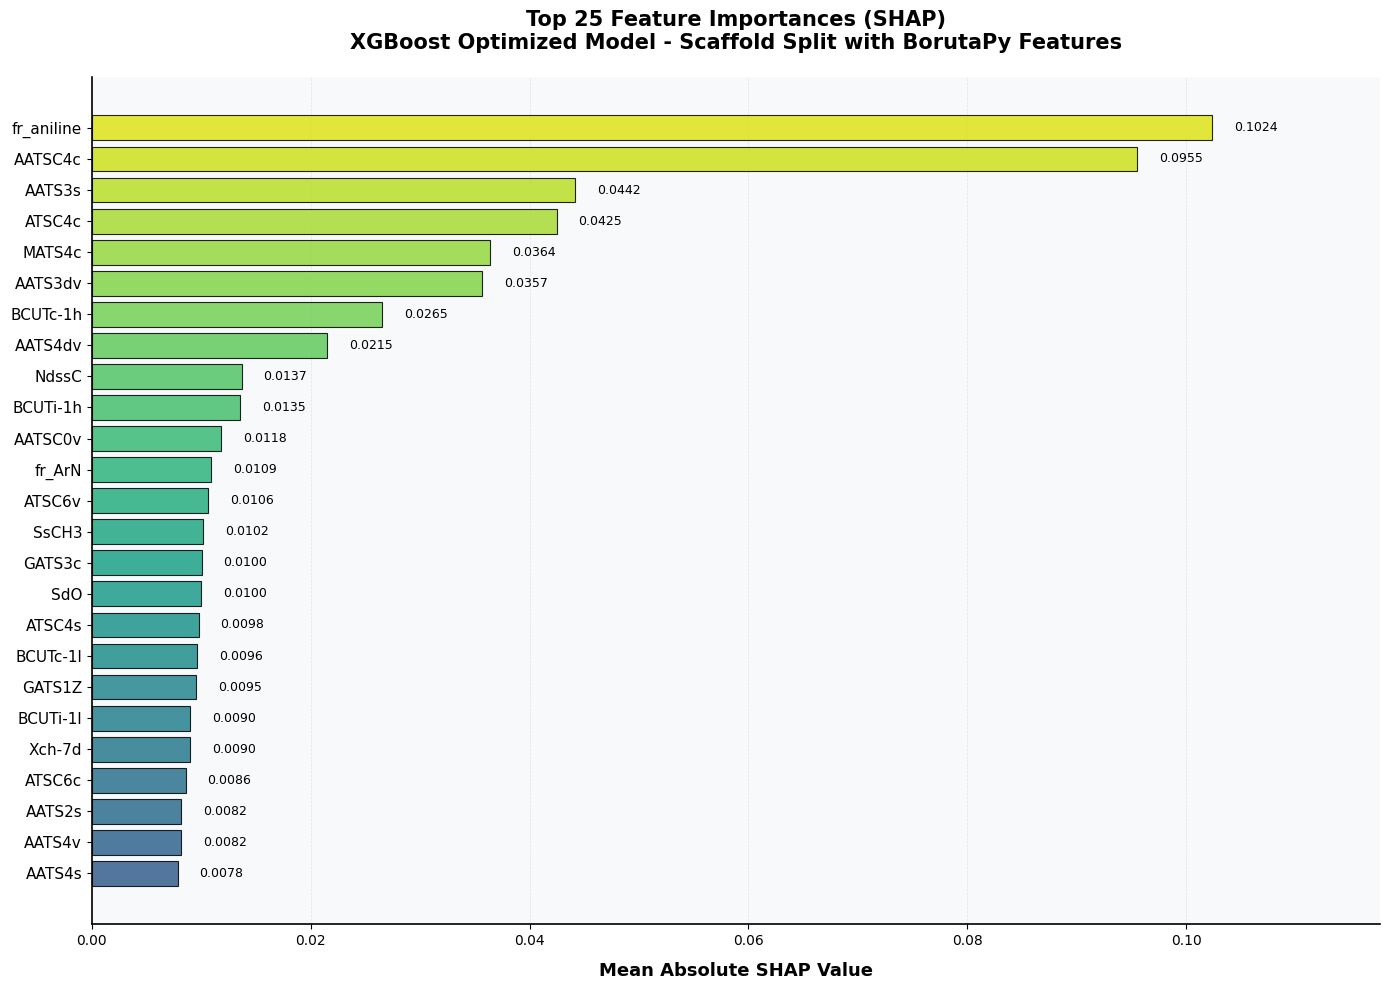

,Feature,Mean_Abs_SHAP
9,fr_aniline,0.102360
68,AATSC4c,0.095537
25,AATS3s,0.044178
36,ATSC4c,0.042480
83,MATS4c,0.036399
16,AATS3dv,0.035678
112,BCUTc-1h,0.026535
17,AATS4dv,0.021520
129,NdssC,0.013677
116,BCUTi-1h,0.013528


In [125]:
# Initialize SHAP for interactive plots
shap.initjs()

# Create SHAP explainer for the XGBoost BorutaPy Scaffold Optimized model (best performer)
explainer = shap.TreeExplainer(classifier_xgb_boruta_scaf_optuna)

# Calculate SHAP values for the training set (using BorutaPy-selected features)
shap_values = explainer(X_train_scaffold_selected)

# Get feature names from the BorutaPy-selected features
feature_names = X_selected.columns

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame with feature names and their importance
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_shap_values
}).sort_values('Mean_Abs_SHAP', ascending=False)

top_25_shap = shap_importance.head(25)

# Create a beautiful SHAP importance plot
fig, ax = plt.subplots(figsize=(14, 10))

# Reverse order for plotting (highest at top)
features_reversed = top_25_shap['Feature'].iloc[::-1].values
values_reversed = top_25_shap['Mean_Abs_SHAP'].iloc[::-1].values

# Create color gradient from light to dark blue
colors = plt.cm.viridis(np.linspace(0.3, 0.95, len(values_reversed)))

# Create horizontal bar plot
bars = ax.barh(range(len(values_reversed)), values_reversed, 
               color=colors, edgecolor='black', linewidth=0.8, alpha=0.85)

# Customize the plot
ax.set_yticks(range(len(features_reversed)))
ax.set_yticklabels(features_reversed, fontsize=11, fontweight='medium')
ax.set_xlabel('Mean Absolute SHAP Value', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Top 25 Feature Importances (SHAP)\nXGBoost Optimized Model - Scaffold Split with BorutaPy Features', 
             fontsize=15, fontweight='bold', pad=20)

# Add value labels on the bars
for i, (bar, value) in enumerate(zip(bars, values_reversed)):
    width = bar.get_width()
    ax.text(width + 0.002, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}',
            ha='left', va='center', fontsize=9, fontweight='medium')

# Add grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Set x-axis limits with some padding
ax.set_xlim(0, max(values_reversed) * 1.15)

# Add a subtle background color
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# Return the DataFrame 
top_25_shap

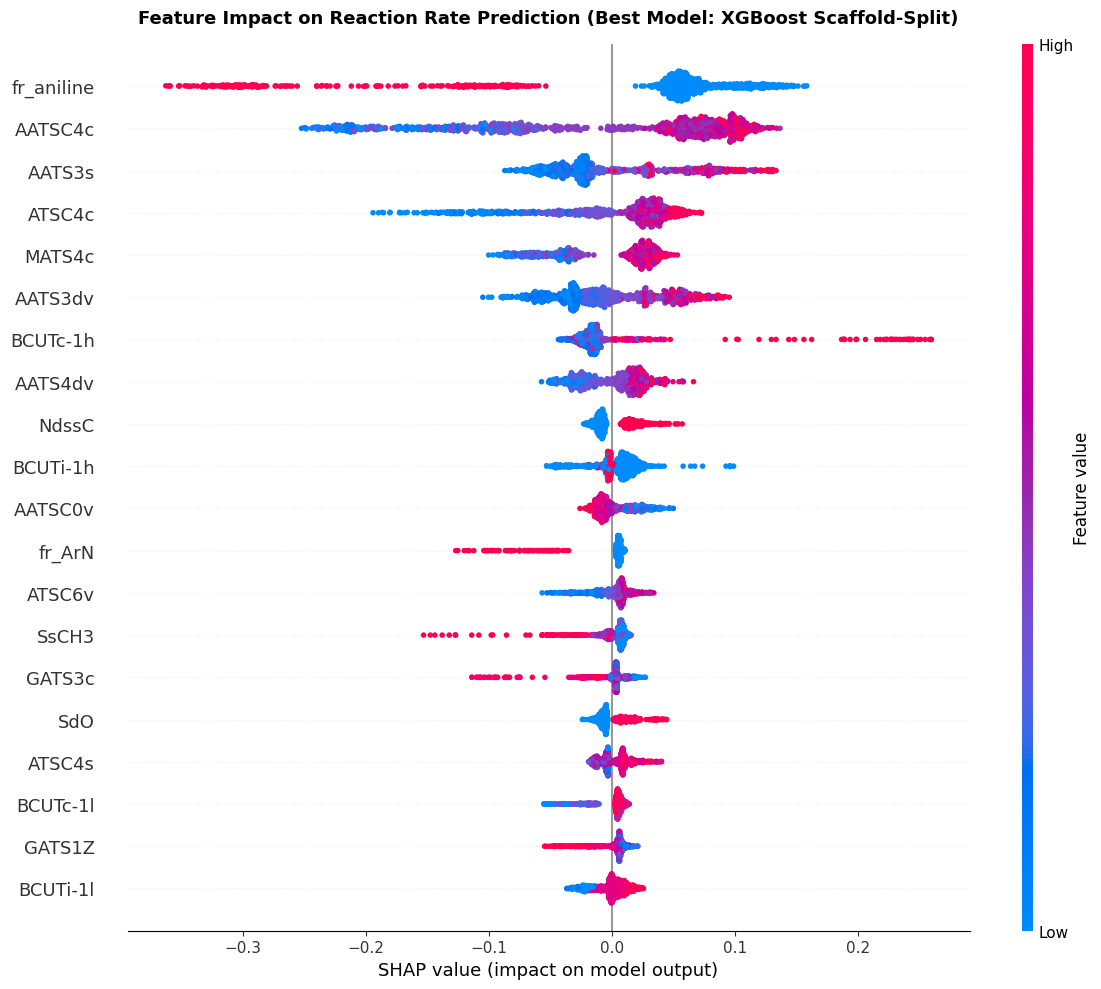

In [136]:
# SHAP Summary Plot - shows which features matter and how
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values.values, X_train_scaffold_selected, 
                  feature_names=feature_names, max_display=20, 
                  show=False, plot_size=(12, 10))
plt.title('Feature Impact on Reaction Rate Prediction (Best Model: XGBoost Scaffold-Split)', 
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()


### Results & Performance Analysis

Compare model performance and understand prediction quality in kcal/mol.


#### Model Performance Comparison


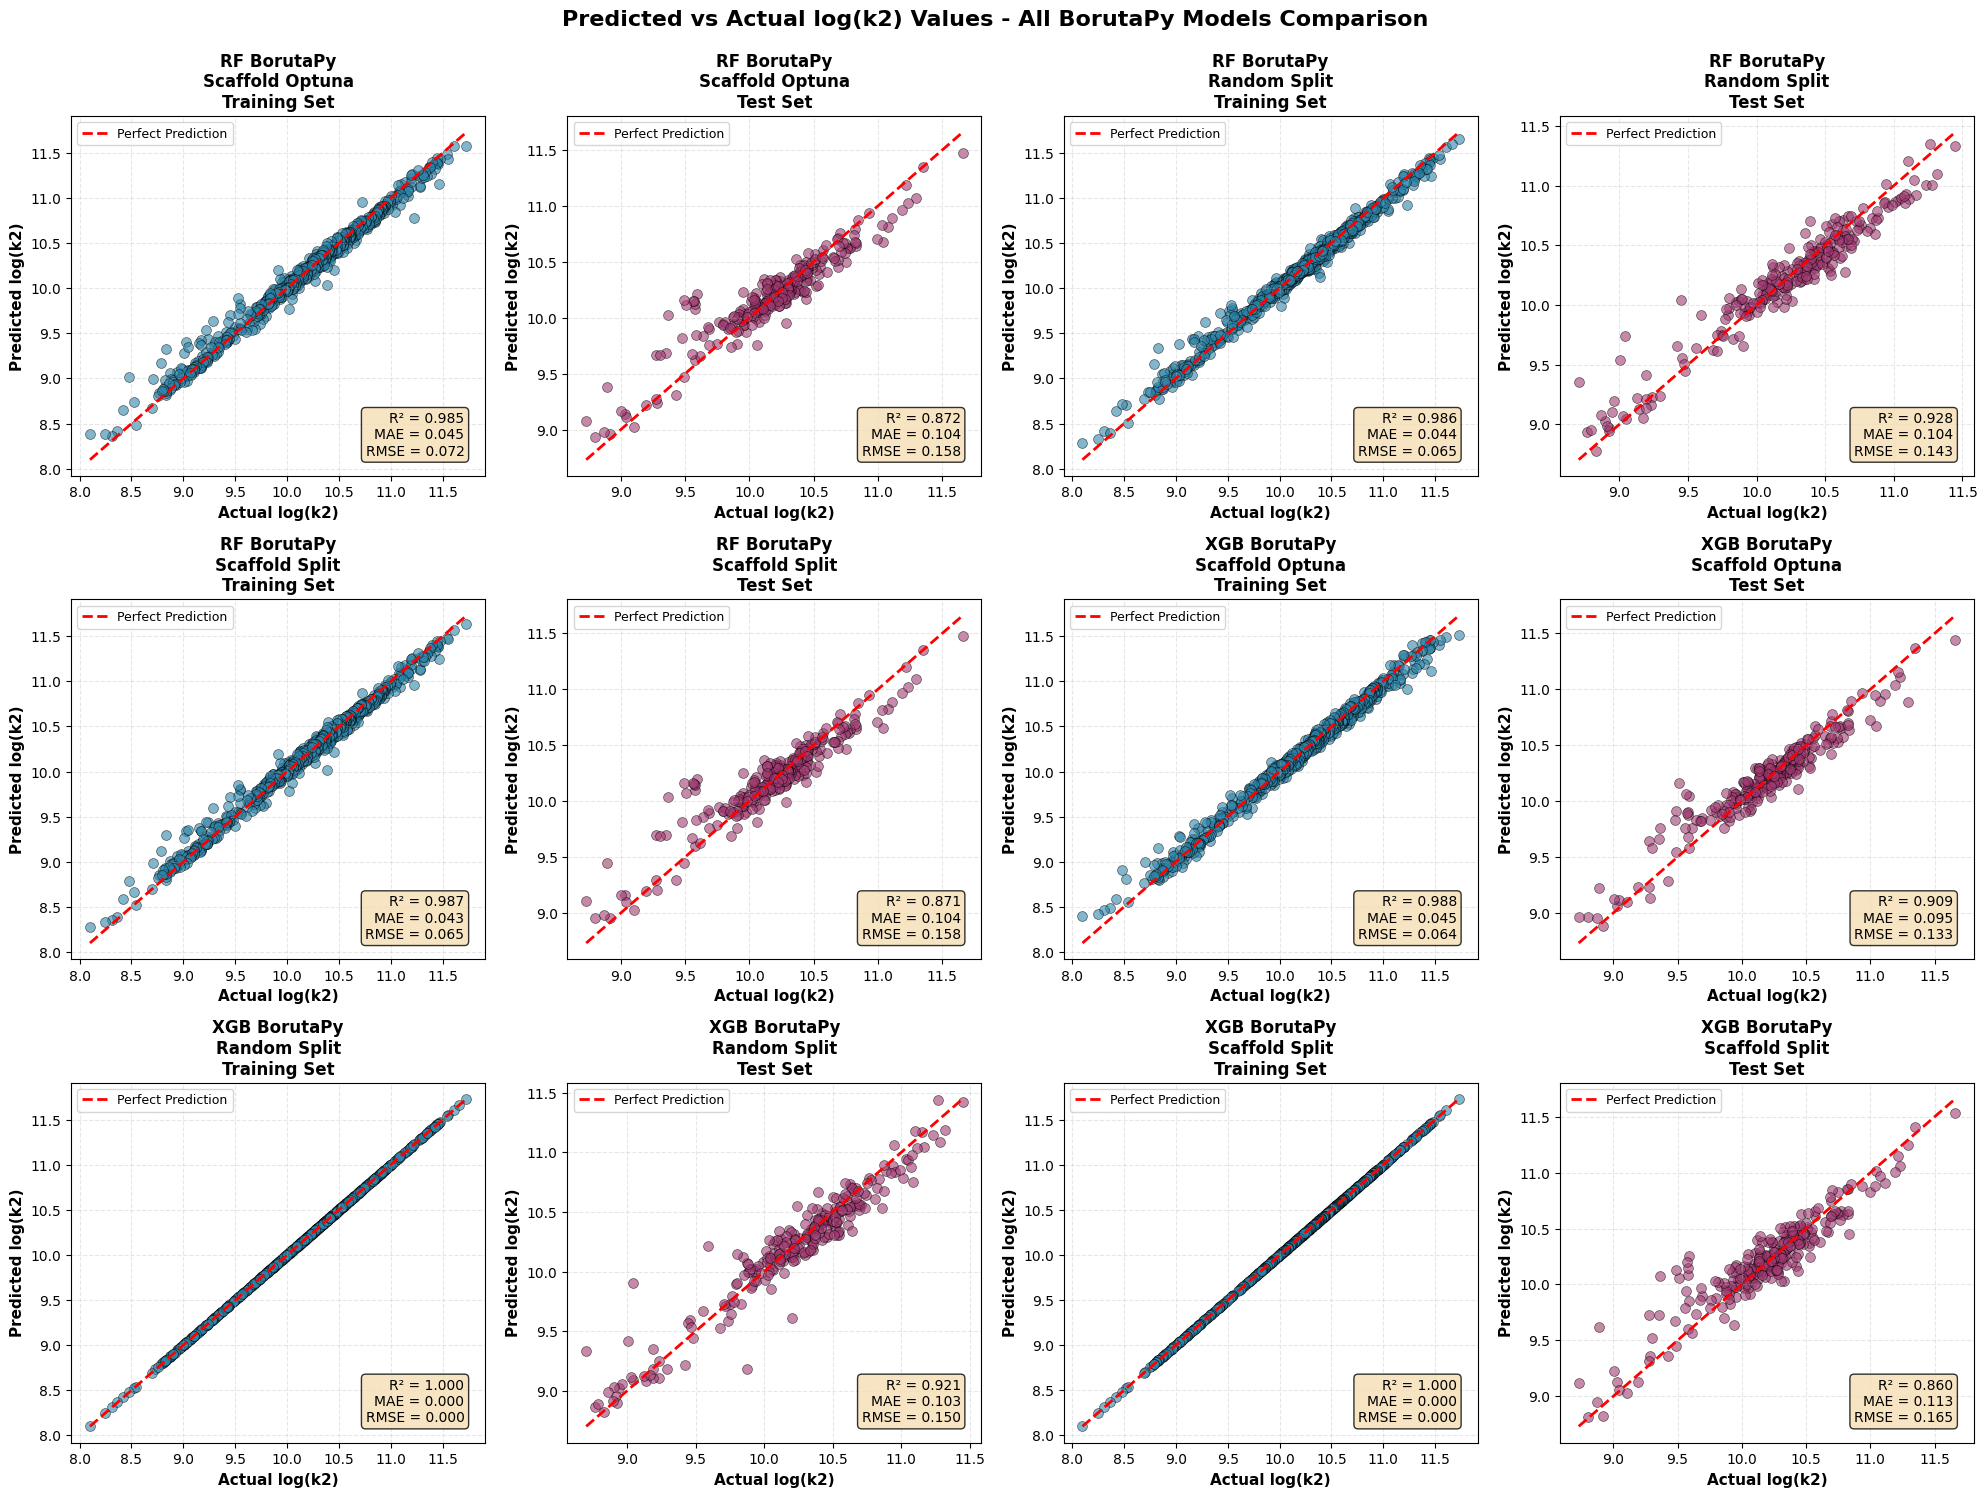

In [ ]:
# Generate predictions for all models (using BorutaPy features)
# Note: Random split uses different train/test splits (X_train_selected, X_test_selected, y_train, y_test)
# Scaffold split uses (X_train_scaffold_selected, X_test_scaffold_selected, y_train_scaffold, y_test_scaffold)

models_dict = {
    'RF BorutaPy\nScaffold Optuna': {
        'model': classifier_rf_boruta_scaf_optuna, 
        'X_train': X_train_scaffold_selected, 
        'X_test': X_test_scaffold_selected,
        'y_train': y_train_scaffold,
        'y_test': y_test_scaffold
    },
    'RF BorutaPy\nRandom Split': {
        'model': classifier_rf_rand_clean,
        'X_train': X_train_selected,
        'X_test': X_test_selected,
        'y_train': y_train,
        'y_test': y_test
    },
    'RF BorutaPy\nScaffold Split': {
        'model': classifier_rf_boruta_scaf_baseline,
        'X_train': X_train_scaffold_selected,
        'X_test': X_test_scaffold_selected,
        'y_train': y_train_scaffold,
        'y_test': y_test_scaffold
    },
    'XGB BorutaPy\nScaffold Optuna': {
        'model': classifier_xgb_boruta_scaf_optuna,
        'X_train': X_train_scaffold_selected,
        'X_test': X_test_scaffold_selected,
        'y_train': y_train_scaffold,
        'y_test': y_test_scaffold
    },
    'XGB BorutaPy\nRandom Split': {
        'model': classifier_xgb_boruta_rand,
        'X_train': X_train_selected,
        'X_test': X_test_selected,
        'y_train': y_train,
        'y_test': y_test
    },
    'XGB BorutaPy\nScaffold Split': {
        'model': classifier_xgb_boruta_scaf_baseline,
        'X_train': X_train_scaffold_selected,
        'X_test': X_test_scaffold_selected,
        'y_train': y_train_scaffold,
        'y_test': y_test_scaffold
    },
}

# Create a 3x2 grid for predicted vs actual plots (6 models, train and test)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Predicted vs Actual log(k2) Values - All BorutaPy Models Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

for idx, (model_name, model_info) in enumerate(models_dict.items()):
    model = model_info['model']
    X_train = model_info['X_train']
    X_test = model_info['X_test']
    y_train = model_info['y_train']
    y_test = model_info['y_test']
    # Train predictions
    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Plot train set (left column)
    ax_train = axes_flat[idx * 2]
    ax_train.scatter(y_train, y_train_pred, alpha=0.6, s=50, 
                     c='#2E86AB', edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_train.min(), y_train_pred.min())
    max_val = max(y_train.max(), y_train_pred.max())
    ax_train.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax_train.set_xlabel('Actual log(k2)', fontsize=11, fontweight='bold')
    ax_train.set_ylabel('Predicted log(k2)', fontsize=11, fontweight='bold')
    ax_train.set_title(f'{model_name}\nTraining Set', fontsize=12, fontweight='bold')
    ax_train.grid(True, alpha=0.3, linestyle='--')
    ax_train.legend(loc='upper left', fontsize=9)
    
    # Add metrics text box
    textstr = f'R² = {train_r2:.3f}\nMAE = {train_mae:.3f}\nRMSE = {train_rmse:.3f}'
    ax_train.text(0.95, 0.05, textstr, transform=ax_train.transAxes, fontsize=10,
                  verticalalignment='bottom', horizontalalignment='right',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Plot test set (right column)
    ax_test = axes_flat[idx * 2 + 1]
    ax_test.scatter(y_test, y_test_pred, alpha=0.6, s=50, 
                    c='#A23B72', edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    ax_test.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax_test.set_xlabel('Actual log(k2)', fontsize=11, fontweight='bold')
    ax_test.set_ylabel('Predicted log(k2)', fontsize=11, fontweight='bold')
    ax_test.set_title(f'{model_name}\nTest Set', fontsize=12, fontweight='bold')
    ax_test.grid(True, alpha=0.3, linestyle='--')
    ax_test.legend(loc='upper left', fontsize=9)
    
    # Add metrics text box
    textstr = f'R² = {test_r2:.3f}\nMAE = {test_mae:.3f}\nRMSE = {test_rmse:.3f}'
    ax_test.text(0.95, 0.05, textstr, transform=ax_test.transAxes, fontsize=10,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Hide unused subplots (we have 6 models x 2 plots = 12 plots in a 3x4 grid)
for i in range(12, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.savefig('model_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


#### Metrics Summary


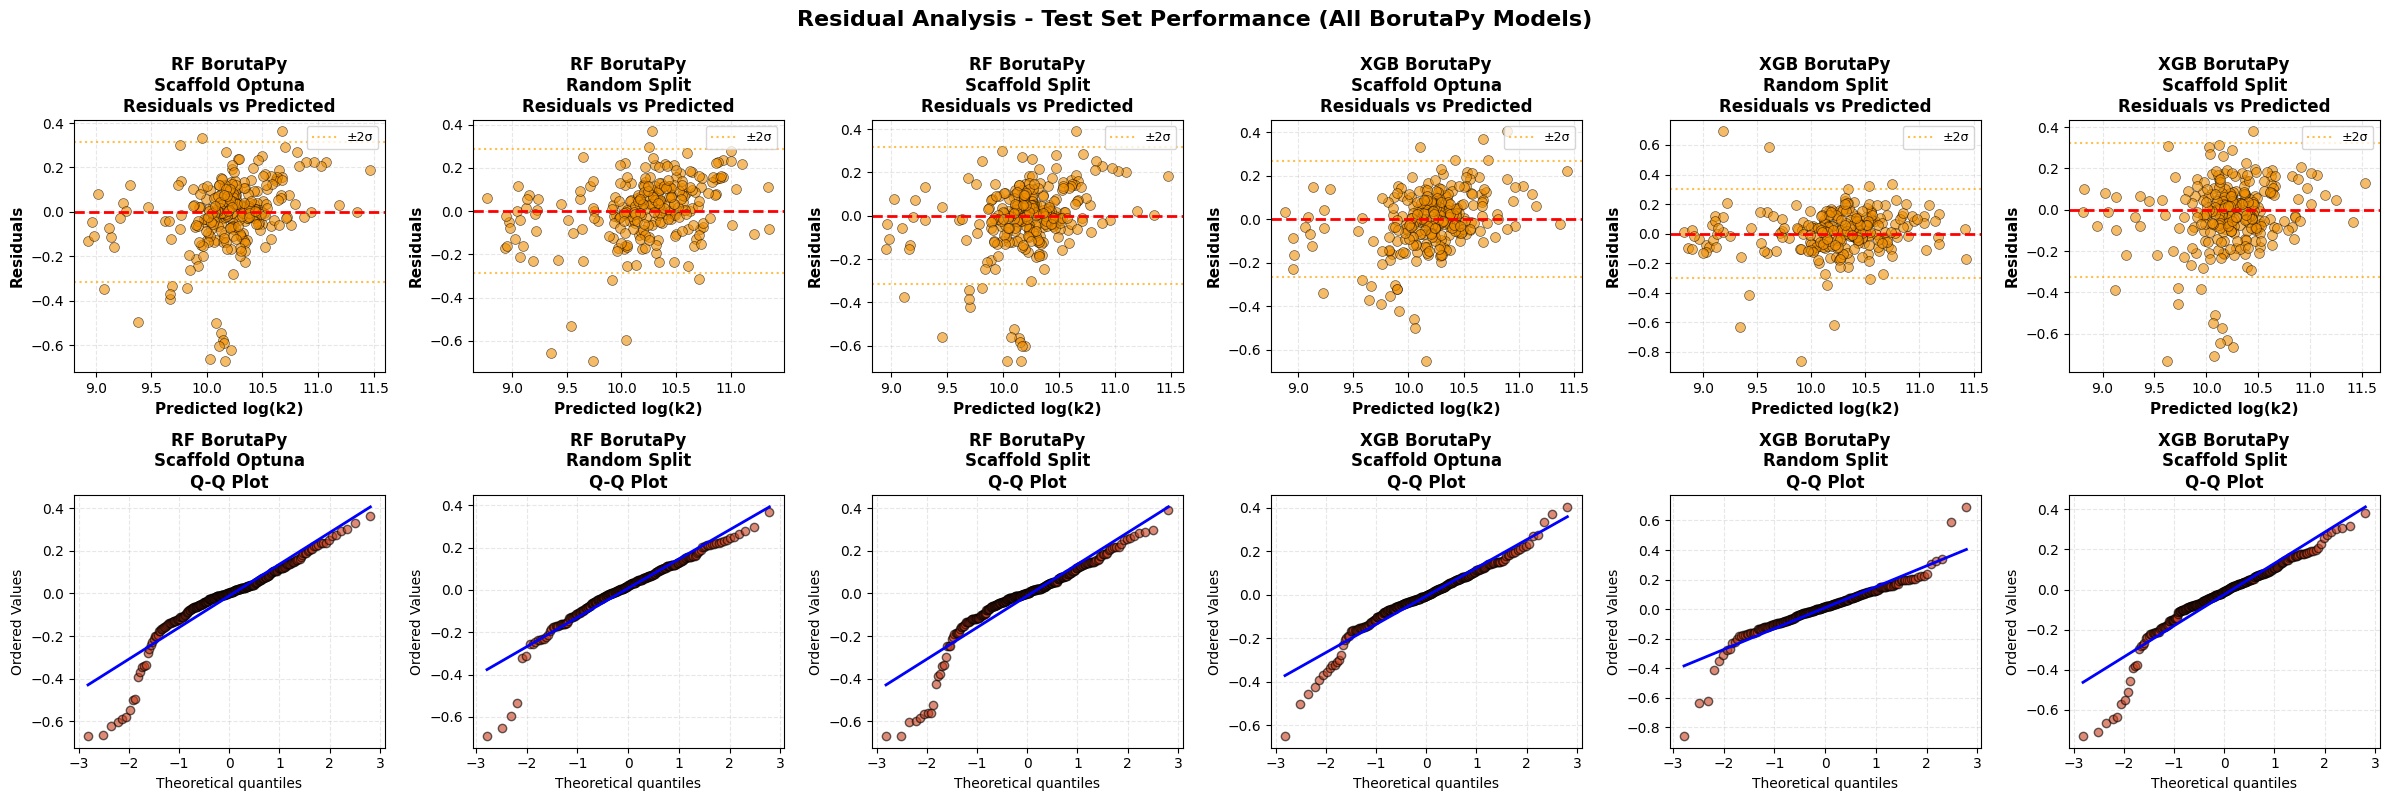

In [ ]:
# Residual plots for all models
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
fig.suptitle('Residual Analysis - Test Set Performance (All BorutaPy Models)', 
             fontsize=16, fontweight='bold', y=0.995)

for idx, (model_name, model_info) in enumerate(models_dict.items()):
    model = model_info['model']
    X_test = model_info['X_test']
    y_test = model_info['y_test']
    
    # Test predictions and residuals
    y_test_pred = model.predict(X_test)
    residuals = y_test - y_test_pred
    
    # Residuals vs Predicted (top row)
    ax1 = axes[0, idx]
    ax1.scatter(y_test_pred, residuals, alpha=0.6, s=50, 
                c='#F18F01', edgecolors='black', linewidth=0.5)
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_xlabel('Predicted log(k2)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Residuals', fontsize=11, fontweight='bold')
    ax1.set_title(f'{model_name}\nResiduals vs Predicted', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Add standard deviation lines
    std_res = np.std(residuals)
    ax1.axhline(y=2*std_res, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='±2σ')
    ax1.axhline(y=-2*std_res, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.legend(loc='upper right', fontsize=9)
    
    # Q-Q plot (bottom row)
    ax2 = axes[1, idx]
    stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.set_title(f'{model_name}\nQ-Q Plot', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.get_lines()[0].set_markerfacecolor('#C73E1D')
    ax2.get_lines()[0].set_markeredgecolor('black')
    ax2.get_lines()[0].set_markersize(6)
    ax2.get_lines()[0].set_alpha(0.6)
    ax2.get_lines()[1].set_color('blue')
    ax2.get_lines()[1].set_linewidth(2)

plt.tight_layout()
plt.savefig('model_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


#### Results Interpretation

**Kfindings from the comparison:**

1. Random split performs better (R² ~0.93 vs ~0.87) but this is expected as the random split has similar molecules in train and test sets which creates a biased outcome. 
2. The scaffold split has slightly less good performance (R² ~0.87, MAE ~0.2 kcal/mol) but tests on unseen unique molecular scaffolds. A MAE of 0.2 kcal/mol is very good for chemical predictions.
3. Both RF and XGB perform quite similar with the scaffold split but XGB is slightly better after Optuna Tuning.


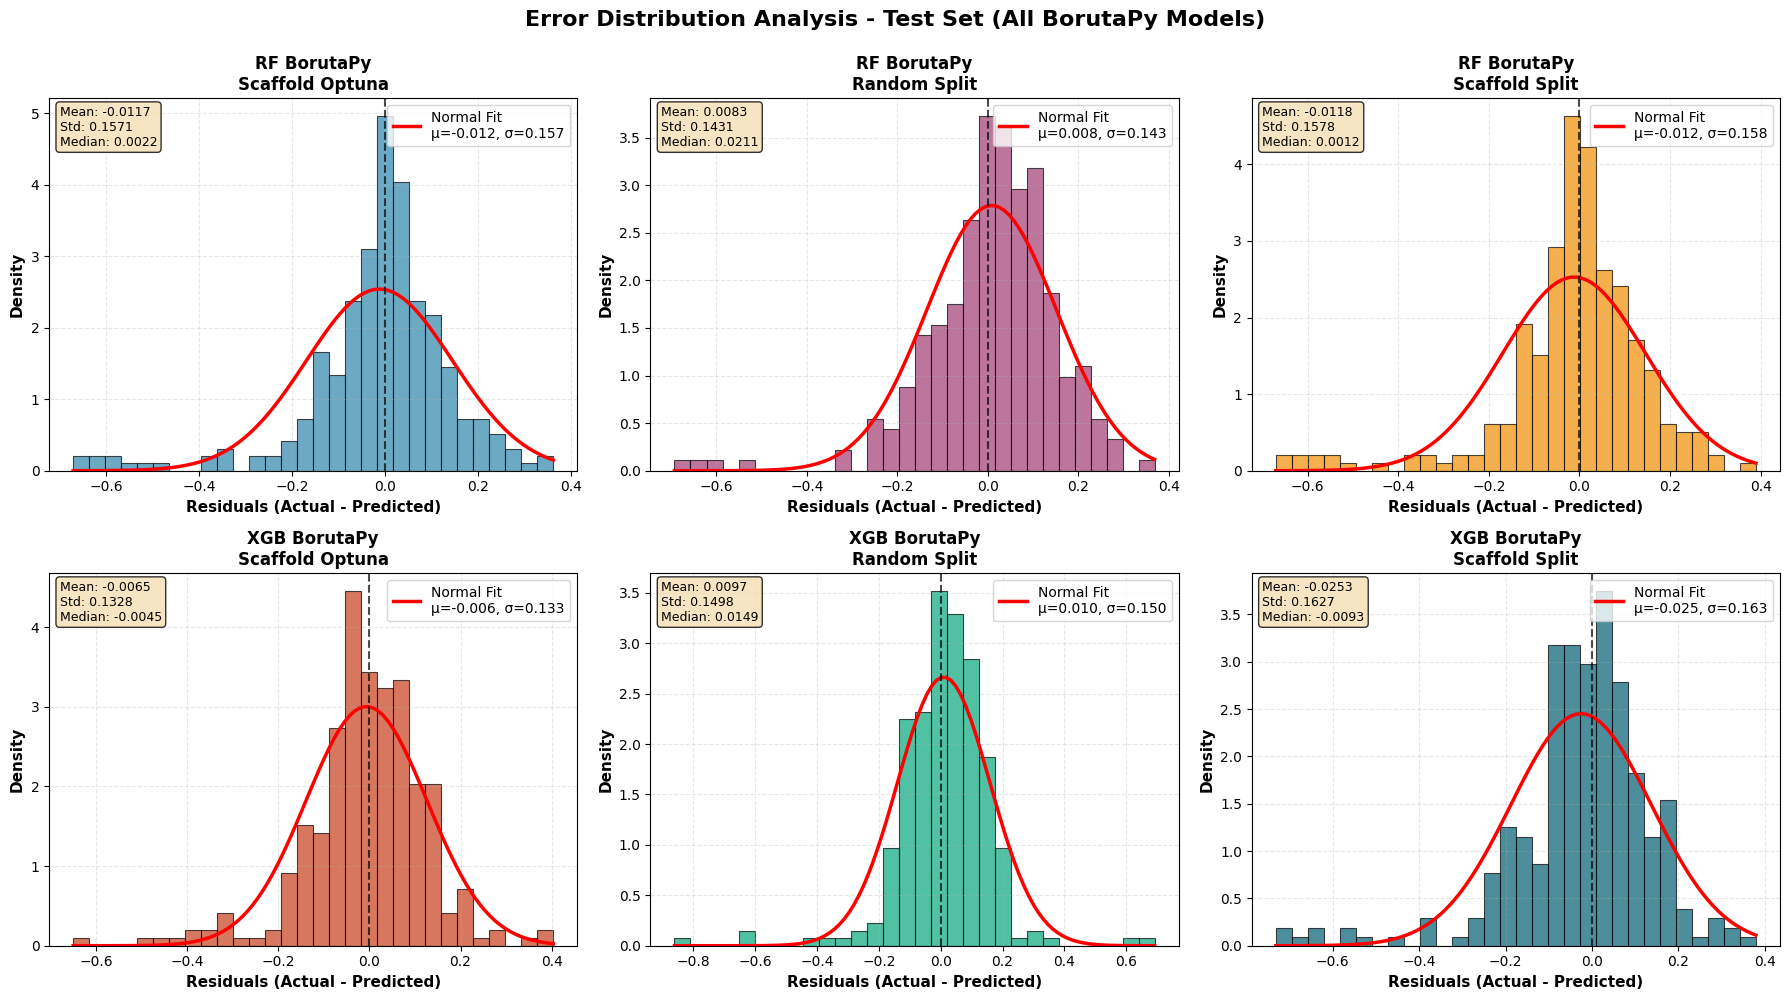

In [138]:
# Error distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Error Distribution Analysis - Test Set (All BorutaPy Models)', 
             fontsize=16, fontweight='bold', y=0.995)

colors_dist = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#06A77D', '#005F73']
axes_flat = axes.flatten()

for idx, (model_name, model_info) in enumerate(models_dict.items()):
    model = model_info['model']
    X_test = model_info['X_test']
    y_test = model_info['y_test']
    
    y_test_pred = model.predict(X_test)
    residuals = y_test - y_test_pred
    
    ax = axes_flat[idx]
    
    # Histogram with KDE
    n, bins, patches = ax.hist(residuals, bins=30, alpha=0.7, color=colors_dist[idx], 
                                edgecolor='black', linewidth=0.8, density=True)
    
    # Fit and plot normal distribution
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label=f'Normal Fit\nμ={mu:.3f}, σ={sigma:.3f}')
    
    ax.set_xlabel('Residuals (Actual - Predicted)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Add statistics box
    textstr = f'Mean: {mu:.4f}\nStd: {sigma:.4f}\nMedian: {np.median(residuals):.4f}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('model_error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


### Final Summary & Conclusions


In [142]:
# Final summary of best model (XGBoost with scaffold split)
best_model = classifier_xgb_boruta_scaf_optuna
y_pred_final = best_model.predict(X_test_scaffold_selected)

final_r2 = r2_score(y_test_scaffold, y_pred_final)
final_mae = mean_absolute_error(y_test_scaffold, y_pred_final)

# Convert to chemically meaningful energy units
R = 0.001987  # kcal/(mol·K)
T = 298.15    # K
conversion = 2.303 * R * T  # From Eyring equation
final_mae_kcal = final_mae * conversion

print("Best performing model: XGBoost + Scaffold Split + BorutaPy")
print(f"Test R²: {final_r2:.3f}")
print(f"Test MAE: {final_mae:.3f} log units")
print(f"Test MAE: {final_mae_kcal:.2f} kcal/mol (ΔG‡)")
print(f"Test samples: {len(y_test_scaffold)}")
print(f"Features used: {X_test_scaffold_selected.shape[1]} (from {X_scaled.shape[1]} descriptors)")


Best performing model: XGBoost + Scaffold Split + BorutaPy
Test R²: 0.909
Test MAE: 0.095 log units
Test MAE: 0.13 kcal/mol (ΔG‡)
Test samples: 281
Features used: 161 (from 1367 descriptors)


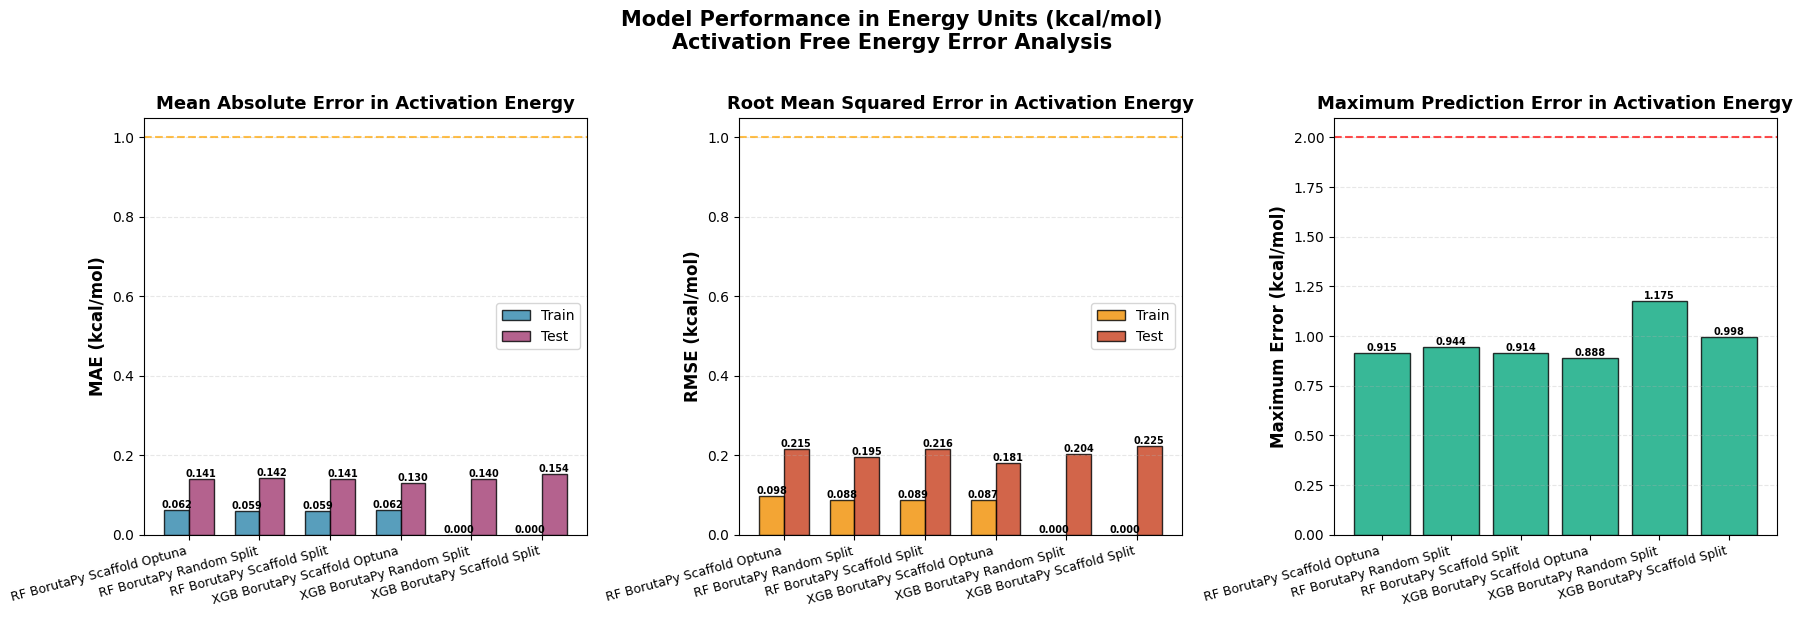

In [ ]:
# Create energy-based comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

x_pos = np.arange(len(metrics_df))
width = 0.35

# 1. MAE in kcal/mol
ax1 = axes[0]
bars1 = ax1.bar(x_pos - width/2, metrics_df['Train MAE (kcal/mol)'], width,
                label='Train', color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = ax1.bar(x_pos + width/2, metrics_df['Test MAE (kcal/mol)'], width,
                label='Test', color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1)

ax1.set_ylabel('MAE (kcal/mol)', fontsize=12, fontweight='bold')
ax1.set_title('Mean Absolute Error in Activation Energy', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_df['Model'], rotation=15, ha='right', fontsize=9)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=1.0, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='1 kcal/mol')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

# 2. RMSE in kcal/mol
ax2 = axes[1]
bars1 = ax2.bar(x_pos - width/2, metrics_df['Train RMSE (kcal/mol)'], width,
                label='Train', color='#F18F01', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = ax2.bar(x_pos + width/2, metrics_df['Test RMSE (kcal/mol)'], width,
                label='Test', color='#C73E1D', alpha=0.8, edgecolor='black', linewidth=1)

ax2.set_ylabel('RMSE (kcal/mol)', fontsize=12, fontweight='bold')
ax2.set_title('Root Mean Squared Error in Activation Energy', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics_df['Model'], rotation=15, ha='right', fontsize=9)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=1.0, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='1 kcal/mol')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

# 3. Max Error in kcal/mol
ax3 = axes[2]
bars = ax3.bar(x_pos, metrics_df['Max Error (kcal/mol)'],
               color='#06A77D', alpha=0.8, edgecolor='black', linewidth=1)

ax3.set_ylabel('Maximum Error (kcal/mol)', fontsize=12, fontweight='bold')
ax3.set_title('Maximum Prediction Error in Activation Energy', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics_df['Model'], rotation=15, ha='right', fontsize=9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.axhline(y=2.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='2 kcal/mol')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

fig.suptitle('Model Performance in Energy Units (kcal/mol)\nActivation Free Energy Error Analysis',
             fontsize=15, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('model_energy_errors_kcal_mol.png', dpi=300, bbox_inches='tight')
plt.show()


#### Absolute Error Analysis

Plot the absolute error distribution. 

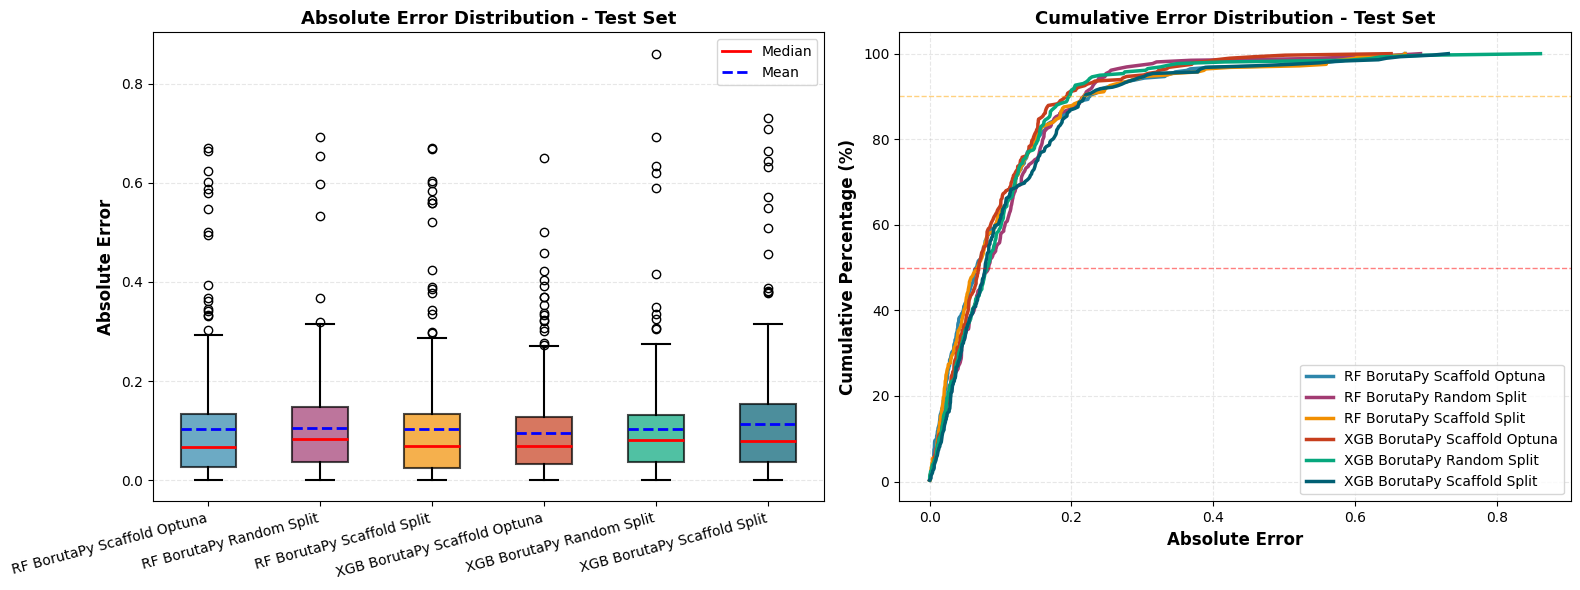

In [133]:
# Absolute error analysis with box plots and cumulative distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare absolute error data
abs_errors_dict = {}
for model_name, model_info in models_dict.items():
    model = model_info['model']
    X_test = model_info['X_test']
    y_test = model_info['y_test']
    
    y_test_pred = model.predict(X_test)
    abs_errors = np.abs(y_test - y_test_pred)
    abs_errors_dict[model_name.replace('\n', ' ')] = abs_errors

# 1. Box plot of absolute errors
ax1 = axes[0]
bp = ax1.boxplot(abs_errors_dict.values(), labels=abs_errors_dict.keys(),
                 patch_artist=True, showmeans=True, meanline=True)

# Color the boxes
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#06A77D', '#005F73']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Customize other elements
for element in ['whiskers', 'fliers', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
plt.setp(bp['medians'], color='red', linewidth=2)
plt.setp(bp['means'], color='blue', linewidth=2, linestyle='--')

ax1.set_ylabel('Absolute Error', fontsize=12, fontweight='bold')
ax1.set_title('Absolute Error Distribution - Test Set', fontsize=13, fontweight='bold')
ax1.set_xticklabels(abs_errors_dict.keys(), rotation=15, ha='right', fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend for mean and median
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linewidth=2, label='Median'),
                   Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='Mean')]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=10)

# 2. Cumulative distribution of absolute errors
ax2 = axes[1]
for (model_name, abs_errors), color in zip(abs_errors_dict.items(), colors):
    sorted_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    ax2.plot(sorted_errors, cumulative, linewidth=2.5, label=model_name, color=color)

ax2.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Error Distribution - Test Set', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Median')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='90th percentile')

plt.tight_layout()
plt.savefig('model_absolute_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


#### Feature Importance Comparison 

Compare the importance of the features in both models so I can analyze those theoretically. 


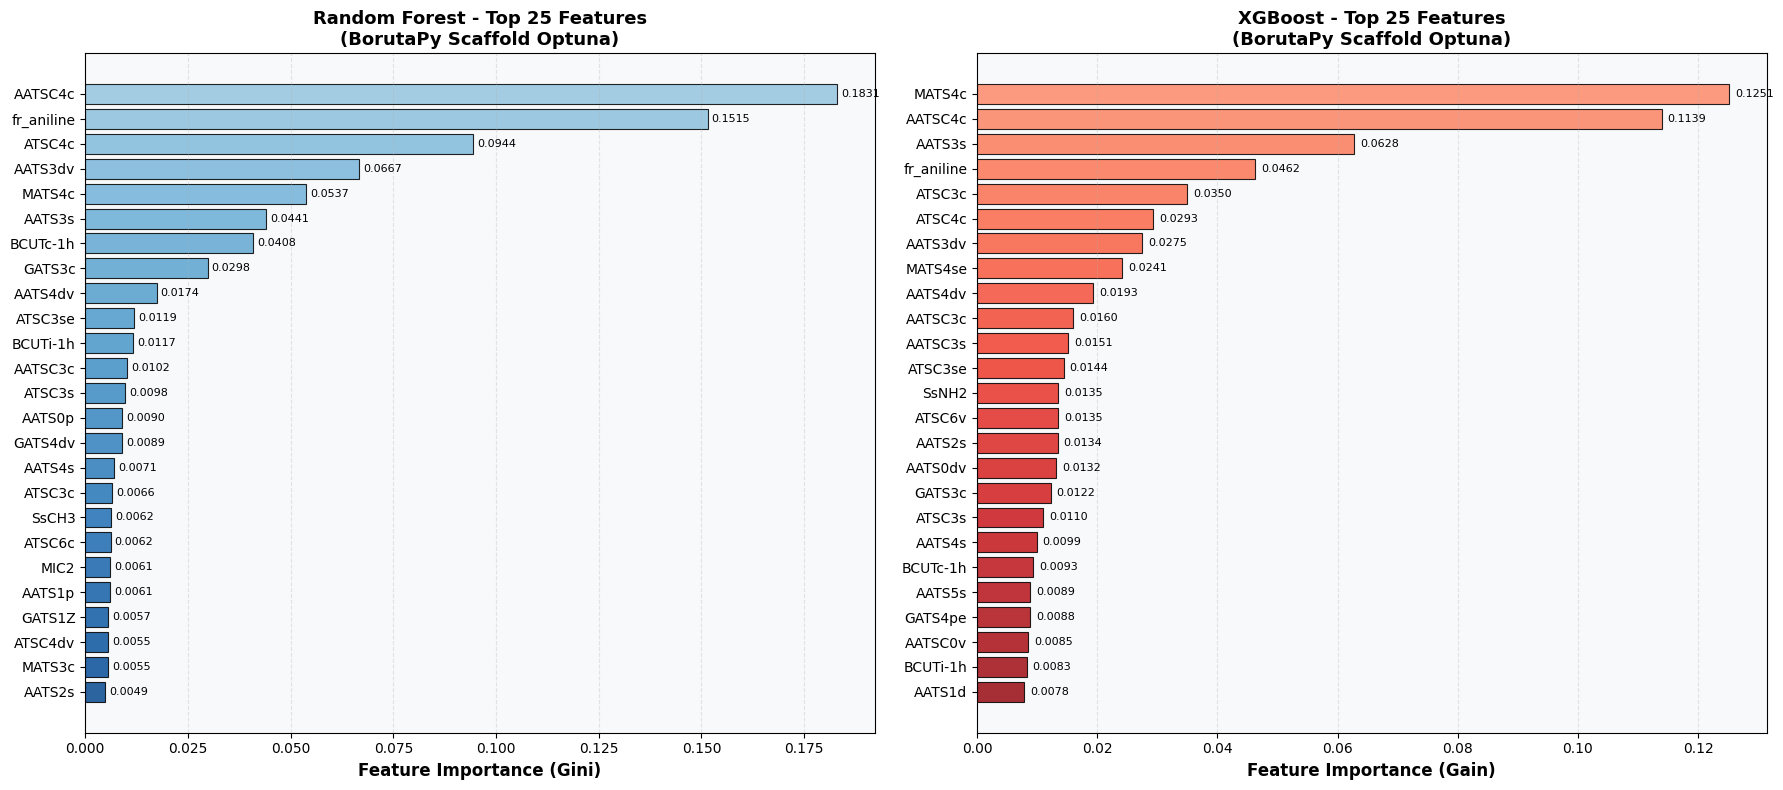

In [134]:
# Compare feature importances between RF and XGB (with BorutaPy features)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Get feature importances from the optimized models
rf_importances = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': classifier_rf_boruta_scaf_optuna.feature_importances_
}).sort_values('Importance', ascending=False).head(25)

xgb_importances = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': classifier_xgb_boruta_scaf_optuna.feature_importances_
}).sort_values('Importance', ascending=False).head(25)

# Plot RF importances
ax1 = axes[0]
colors_rf = plt.cm.Blues(np.linspace(0.4, 0.9, len(rf_importances)))
bars1 = ax1.barh(range(len(rf_importances)), rf_importances['Importance'].iloc[::-1],
                 color=colors_rf[::-1], edgecolor='black', linewidth=0.8, alpha=0.85)
ax1.set_yticks(range(len(rf_importances)))
ax1.set_yticklabels(rf_importances['Feature'].iloc[::-1], fontsize=10)
ax1.set_xlabel('Feature Importance (Gini)', fontsize=12, fontweight='bold')
ax1.set_title('Random Forest - Top 25 Features\n(BorutaPy Scaffold Optuna)', 
              fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, rf_importances['Importance'].iloc[::-1])):
    width = bar.get_width()
    ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', ha='left', va='center', fontsize=8)

# Plot XGB importances
ax2 = axes[1]
colors_xgb = plt.cm.Reds(np.linspace(0.4, 0.9, len(xgb_importances)))
bars2 = ax2.barh(range(len(xgb_importances)), xgb_importances['Importance'].iloc[::-1],
                 color=colors_xgb[::-1], edgecolor='black', linewidth=0.8, alpha=0.85)
ax2.set_yticks(range(len(xgb_importances)))
ax2.set_yticklabels(xgb_importances['Feature'].iloc[::-1], fontsize=10)
ax2.set_xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
ax2.set_title('XGBoost - Top 25 Features\n(BorutaPy Scaffold Optuna)', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, xgb_importances['Importance'].iloc[::-1])):
    width = bar.get_width()
    ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('feature_importance_rf_vs_xgb.png', dpi=300, bbox_inches='tight')
plt.show()
